# Imports and dataset

In [1]:
import zipfile
from airfoil_diffusion.airfoil_datasets import *
from airfoil_diffusion.networks import *
from airfoil_diffusion.trainer import *
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if not os.path.exists("./datasets/1_parameter/data/"):
    files=[file for file in os.listdir("./datasets/1_parameter/") if file.endswith(".zip")]
    for file in tqdm(files): 
        f=zipfile.ZipFile("./datasets/1_parameter/"+file,'r')
        for file in f.namelist():
            f.extract(file,"./datasets/1_parameter/data/")
        f.close() 
        
df_train=FileDataFiles("./datasets/1_parameter/train_cases.txt",base_path="./datasets/1_parameter/data/")
df_test=FileDataFiles("./datasets/1_parameter/test_cases.txt",base_path="./datasets/1_parameter/data/")
df_all=DataFiles(df_train.case_list+df_test.case_list)

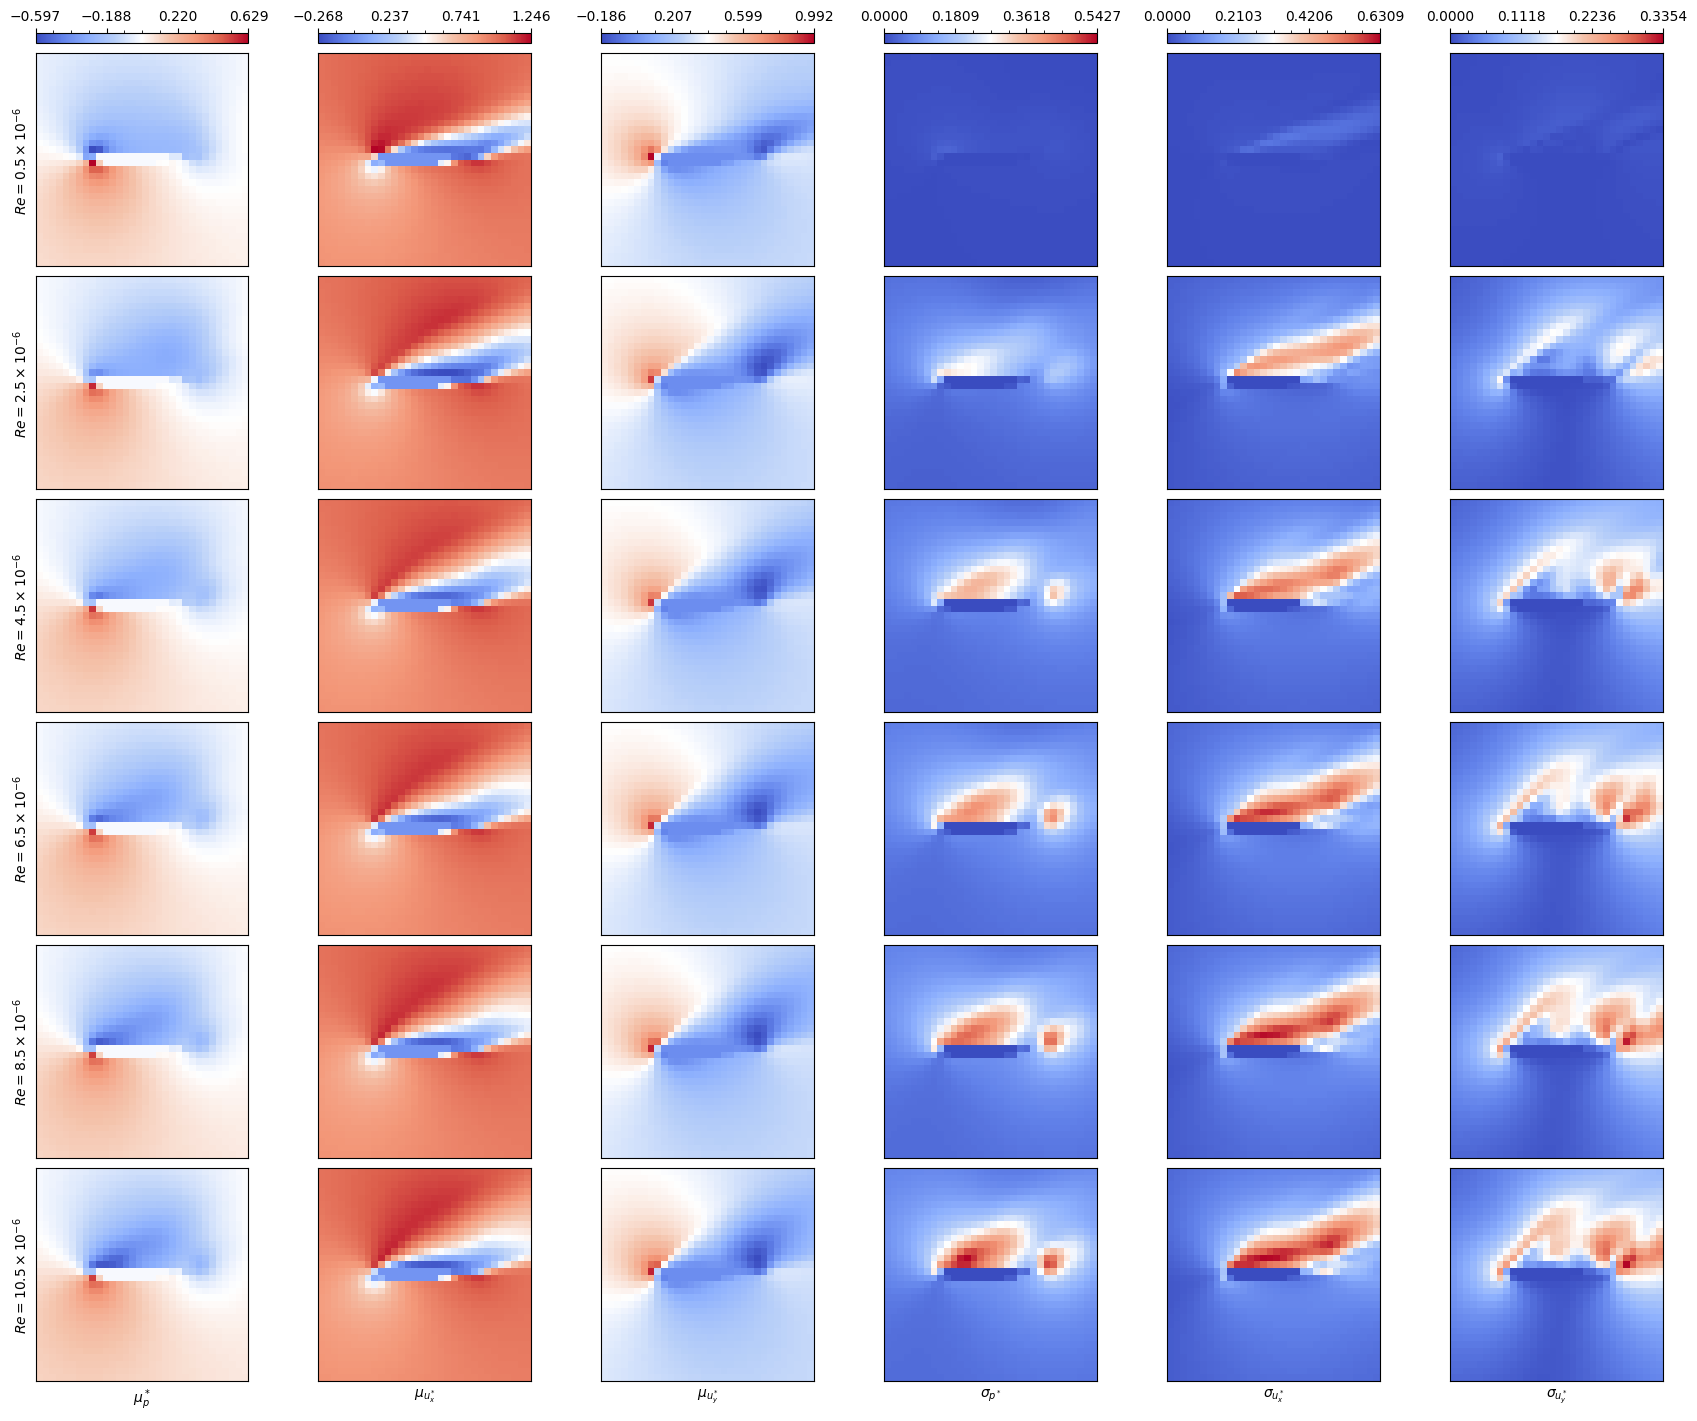

In [2]:
df_test.sort()
std_field_test_gd=[]
mean_field_test_gd=[]
inputs_test=[]
samples_gd=[]
for case in df_test.get_simulation_cases():
    datas=[]
    selected_cases=df_test.select_simulation_cases([case])
    for case in selected_cases:
        raw_data=read_single_file(case['path']+case['file_name'],model="dimless",scale_factor=0.25)
        datas.append(
            raw_data[3:]
            )
    inputs_test.append(read_single_file(case['path']+case['file_name'],model="normalized",scale_factor=0.25)[0:3])
    samples_gd.append(np.stack(datas,axis=0))
    std_field_test_gd.append(samples_gd[-1].std(axis=0))   
    mean_field_test_gd.append(samples_gd[-1].mean(axis=0))
std_field_test_gd=np.stack(std_field_test_gd,axis=0)
mean_field_test_gd=np.stack(mean_field_test_gd,axis=0)

from airfoil_diffusion.plotter import *
CHANNEL_NAME_MEAN=[r"$\mu_p^*$",r"$\mu_{u_x^*}$",r"$\mu_{u_y^*}$"]
CHANNEL_NAME_STD=[r"$\sigma_{p^*}$",r"$\sigma_{u_x^*}$",r"$\sigma_{u_y^*}$"]
show_each_channel(np.concatenate([mean_field_test_gd,std_field_test_gd],axis=1),
                  channel_names=CHANNEL_NAME_MEAN+CHANNEL_NAME_STD,
                  case_names=[r"$Re={}\times$".format(0.5 +2*i)+"$10^{-6}$" for i in range(6)],transpose=True,inverse_y=True)

In [3]:
def _prune(network: nn.Module, prune_type="L2", pruning_percentage=0.1):
    norm_n = {'L1': 1, 'L2': 2}[prune_type]

    for module in network.modules():
        if type(module) is nn.Conv2d and module.out_channels > 3:
            prune.ln_structured(module, 'weight', amount=pruning_percentage, dim=0, n=norm_n)


def prune_remove(network):
    for module in network.modules():
        if type(module) is nn.Conv2d and module.out_channels > 3 and prune.is_pruned(module):  
            prune.remove(module, 'weight')


# Sampling

In [4]:
def sample_diffusion(network,input_field,num_diffusion_sample=100):
    network.eval();network.to(device);predictions=[]
    batch_size=25;N_all=num_diffusion_sample
    diffuser=Cos2ParamsDiffuser(200,device=device)
    while True:
        if N_all<=0:
            break
        if N_all<batch_size:
            batch_size_now=N_all
            N_all=0
        else:
            N_all-=batch_size
            batch_size_now=batch_size
        prediction_batch=normalized2dimless(diffuser.sample_from_noise(network,input_field.to(device).repeat(batch_size_now,1,1,1),show_progress=False))
        predictions.append(prediction_batch.detach().cpu().numpy())
    predictions=np.concatenate(predictions,axis=0)
    return np.mean(predictions,axis=0),np.std(predictions,axis=0),predictions

def evaluate_sparcity(model):
    total_params = 0
    total_zeros = 0

    for name, module in model.named_modules():
        if hasattr(module, "weight"):
            num_params = sum(p.numel() for p in module.parameters())
            total_params += num_params
            total_zeros += torch.sum(module.weight == 0)

    return total_params, total_zeros.item()

In [5]:
network_configs = {
    "attention_layers": [2, 3],
    "condition_layers": [-2],
    "depth_each_layer": 2,
    "dim_basic": 16,
    "dim_condition": 3,
    "dim_encoded_time": 8,
    "dim_in": 3,
    # "dim_multipliers": [1, 2, 4, 4],
    # "dim_multipliers": [2, 2, 2, 2],
    # "dim_multipliers": [1, 1, 1, 1],
    "dim_multipliers": [2, 2],
    "dim_out": 3,
    "heads_attention": 4,
    "linear_attention": False,
    "skip_connection_scale": 0.707,
    "use_input_condition": True
}
dif_network = AifNet(**network_configs)


In [6]:
# _prune(dif_network)
# prune_remove(dif_network)

In [7]:
experiments = {
    "ref": "2024-08-10-10_28_37",
    "1": "2024-08-10-14_23_42",
    "2": "2024-08-10-19_08_20",
    "5": "2024-08-10-23_53_39",
    "10": "2024-08-11-04_40_45",
    "50": "2024-08-11-09_25_44",
    "100": "2024-08-11-14_09_58",
    "1000": "2024-08-11-18_56_30",
    "10000": "2024-08-11-23_42_05"
}

experiments2 = {
    "1": "2024-08-29-09_09_53",
    "2": "2024-08-29-13_18_52",
    "5": "2024-08-29-17_24_05",
    "10": "2024-08-29-21_28_30",
    "50": "2024-08-30-01_35_28",
    "100": "2024-08-30-05_41_30",
    "1000": "2024-08-30-09_49_14",
    "10000": "2024-08-30-14_22_01",
    "ref": "2024-09-01-16_22_58"
}

In [8]:
experiments_ref = [
    "2024-09-03-14_14_55",
    "2024-09-04-11_32_42",
    "2024-09-04-15_31_36",
    "2024-09-04-19_28_15",
    "2024-09-04-23_23_51",
    "2024-09-05-03_19_05",
]

In [9]:
experiments_prune_22 = [
"2024-09-25-17_02_57",
"2024-09-25-19_36_34",
"2024-09-25-22_10_41",
"2024-09-26-00_44_28",
"2024-09-26-03_17_47",
"2024-09-26-05_50_46",
]

In [10]:

# model_weights = f"./training/single_parameter/32/training/{experiments2['10000']}/checkpoints/checkpoint_125000.pt"
# model_weights = f"./training/single_parameter/32/training/{experiments_ref[4]}/checkpoints/checkpoint_125000.pt"
# model_weights = f"./training/single_parameter/32/training/2024-08-29-09_09_53/checkpoints/checkpoint_125000.pt"
model_weights = f"./training/single_parameter/32/training/2024-09-16-16_16_10/checkpoints/model.pt"
dif_network = AifNet(**network_configs)
# _prune(dif_network)
dif_network.load_state_dict(torch.load(model_weights)["network"])
# prune_remove(dif_network)

total_w, n_zeros = evaluate_sparcity(dif_network)
print(f"Sparse: {100 * n_zeros / total_w:.2f}%")
print(f"Non zeros: {total_w - n_zeros}")


Sparse: 72.04%
Non zeros: 43530


In [11]:
iters = 10

mean_mse = np.zeros(iters)
mean_var = np.zeros(iters)
for i in range(iters):
    print("Iteration", i)
    for index in range(6):
        input_field = inputs_test[index].unsqueeze(0)

        mean, std, samples_diffusion = sample_diffusion(dif_network, input_field, num_diffusion_sample=100)
        result_diffusion = np.concatenate([mean, std], axis=0)
        result_ground_truth = np.concatenate([mean_field_test_gd[index], std_field_test_gd[index]], axis=0)

        # show_each_channel([result_ground_truth, result_diffusion], 
        #                 channel_names=CHANNEL_NAME_MEAN+CHANNEL_NAME_STD, 
        #                 case_names=["Ground truth", "Diffusion"], transpose=True, inverse_y=True)

        mean_mse[i] += np.mean((result_diffusion[0:3] - result_ground_truth[0:3])**2)
        mean_var[i] += np.mean((result_diffusion[3:6] - result_ground_truth[3:6])**2)

    mean_mse[i] /= 6
    mean_var[i] /= 6

print(f"{np.mean(mean_mse)*1e3:.3f}+/-{np.std(mean_mse)*1e3:.3f} | {np.mean(mean_var)*1e3:.3f}+/-{np.std(mean_var)*1e3:.3f}")


Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
0.917+/-0.092 | 3.233+/-0.116


In [10]:
for path in experiments_prune_22:
    print("Experiment", path)
    dif_network = AifNet(**network_configs)
    model_weights = f"./training/single_parameter/32/training/{path}/checkpoints/model.pt"
    dif_network.load_state_dict(torch.load(model_weights)["network"])

    iters = 10

    mean_mse = np.zeros(iters)
    mean_var = np.zeros(iters)
    for i in range(iters):
        print("Iteration", i)
        for index in range(6):
            input_field = inputs_test[index].unsqueeze(0)

            mean, std, samples_diffusion = sample_diffusion(dif_network, input_field, num_diffusion_sample=100)
            result_diffusion = np.concatenate([mean, std], axis=0)
            result_ground_truth = np.concatenate([mean_field_test_gd[index], std_field_test_gd[index]], axis=0)

            mean_mse[i] += np.mean((result_diffusion[0:3] - result_ground_truth[0:3])**2)
            mean_var[i] += np.mean((result_diffusion[3:6] - result_ground_truth[3:6])**2)

        mean_mse[i] /= 6
        mean_var[i] /= 6

    print(f"{np.mean(mean_mse)*1e3:.3f}+/-{np.std(mean_mse)*1e3:.3f} | {np.mean(mean_var)*1e3:.3f}+/-{np.std(mean_var)*1e3:.3f}")


Experiment 2024-09-25-17_02_57
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
20.310+/-8.991 | 1028.579+/-669.688
Experiment 2024-09-25-19_36_34
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
8.621+/-0.160 | 442.321+/-0.807
Experiment 2024-09-25-22_10_41
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
1.316+/-0.073 | 6.427+/-0.114
Experiment 2024-09-26-00_44_28
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
1754.218+/-387.089 | 94897.632+/-11479.616
Experiment 2024-09-26-03_17_47
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
1563993429333.333+/-79424924777.999 | 4185867613866.667+/-168186652139.984
Experiment 2024-09-26-05_50_4

In [37]:
def test_mean_vals(model, iters=5, diff_samples=50):
    mean_mean = np.zeros(6)
    mean_var  = np.zeros(6)
    for i in range(iters):
        for index in range(6):
            input_field  = inputs_test[index].unsqueeze(0)
            mean, std, _ = sample_diffusion(model, input_field, num_diffusion_sample=diff_samples)
            mean_mean[index] += np.mean(mean[2])
            mean_var[index]  += np.mean(std[2])

    mean_mean /= iters
    mean_var  /= iters

    return mean_mean, mean_var


In [38]:
[(0.5 +2*i) for i in range(6)] # x 10^-6

[0.5, 2.5, 4.5, 6.5, 8.5, 10.5]

In [49]:
mean_gt = [np.mean(mean_field_test_gd[index][2]) for index in range(6)]
std_gt  = [np.mean(std_field_test_gd[index][2]) for index in range(6)]
mean_gt, std_gt

([0.28578886, 0.28309137, 0.27792132, 0.27733344, 0.27739716, 0.27713117],
 [0.003934413, 0.053627454, 0.0686748, 0.076484606, 0.08142848, 0.0851496])

In [40]:
test_iterations = 10
diff_samples = 100

In [41]:
network_configs["dim_multipliers"] = [1, 1, 1, 1]
model = AifNet(**network_configs)
model_weights = f"./training/single_parameter/32/training/{experiments['ref']}/checkpoints/checkpoint_125000.pt"
model.load_state_dict(torch.load(model_weights)["network"])
ref_mean, ref_std = test_mean_vals(model, iters=test_iterations, diff_samples=diff_samples)
ref_mean, ref_std

(array([0.28751866, 0.28171363, 0.28027744, 0.27913406, 0.27904225,
        0.27826331]),
 array([0.02558507, 0.0476161 , 0.06846342, 0.07717341, 0.07741012,
        0.08413155]))

In [42]:
network_configs["dim_multipliers"] = [2, 2, 2, 2]
model = AifNet(**network_configs)
model_weights = f"./training/single_parameter/32/training/{experiments2['ref']}/checkpoints/checkpoint_125000.pt"
model.load_state_dict(torch.load(model_weights)["network"])
ref2_mean, ref2_std = test_mean_vals(model, iters=test_iterations, diff_samples=diff_samples)
ref2_mean, ref2_std

(array([0.28433704, 0.28072837, 0.27780149, 0.27621502, 0.27828289,
        0.27724923]),
 array([0.03151182, 0.0439545 , 0.06398213, 0.06956174, 0.07565071,
        0.07944728]))

In [43]:
model_weights = f"./training/single_parameter/32/training/{experiments2['2']}/checkpoints/checkpoint_125000.pt"
model.load_state_dict(torch.load(model_weights)["network"])
inter_2_mean, inter_2_std = test_mean_vals(model, iters=test_iterations, diff_samples=diff_samples)
inter_2_mean, inter_2_std

(array([0.28503076, 0.28082573, 0.27976631, 0.28037145, 0.27748695,
        0.27794895]),
 array([0.03249867, 0.04678801, 0.07208039, 0.07924504, 0.08328658,
        0.08320709]))

In [44]:
model_weights = f"./training/single_parameter/32/training/{experiments2['50']}/checkpoints/checkpoint_125000.pt"
model.load_state_dict(torch.load(model_weights)["network"])
inter_50_mean, inter_50_std = test_mean_vals(model, iters=test_iterations, diff_samples=diff_samples)
inter_50_mean, inter_50_std

(array([0.28375987, 0.28207645, 0.27707246, 0.27739181, 0.27737879,
        0.27597212]),
 array([0.03252634, 0.04609111, 0.06976686, 0.07728952, 0.08379174,
        0.08402668]))

In [45]:
model_weights = f"./training/single_parameter/32/training/{experiments2['1000']}/checkpoints/checkpoint_125000.pt"
model.load_state_dict(torch.load(model_weights)["network"])
inter_1000_mean, inter_1000_std = test_mean_vals(model, iters=test_iterations, diff_samples=diff_samples)
inter_1000_mean, inter_1000_std

(array([0.28496564, 0.2833428 , 0.27907914, 0.28099867, 0.28009364,
        0.27818684]),
 array([0.0312176 , 0.04513662, 0.07203288, 0.07948845, 0.08173598,
        0.08304775]))

In [46]:
model_weights = f"./training/single_parameter/32/training/{experiments2['5']}/checkpoints/checkpoint_125000.pt"
model.load_state_dict(torch.load(model_weights)["network"])
inter_5_mean, inter_5_std = test_mean_vals(model, iters=test_iterations, diff_samples=diff_samples)
inter_5_mean, inter_5_std

(array([0.2842986 , 0.2814936 , 0.27690634, 0.2761455 , 0.27504034,
        0.27772862]),
 array([0.03233749, 0.04562784, 0.0678923 , 0.07562045, 0.08002743,
        0.07987797]))

Text(0, 0.5, '$\\sigma_{y}$ ')

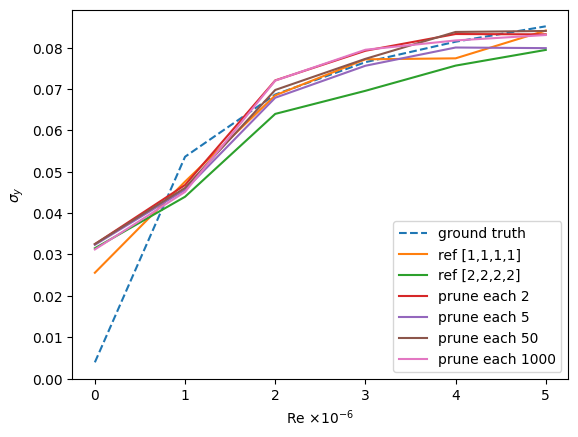

In [51]:
REs = [0.5, 2.5, 4.5, 6.5, 8.5, 10.5]
plt.plot(std_gt, "--", label="ground truth")
plt.plot(ref_std, label="ref [1,1,1,1]")
plt.plot(ref2_std, label="ref [2,2,2,2]")
plt.plot(inter_2_std, label="prune each 2")
plt.plot(inter_5_std, label="prune each 5")
plt.plot(inter_50_std, label="prune each 50")
plt.plot(inter_1000_std, label="prune each 1000")
plt.legend()
plt.xlabel("Re $\\times 10^{-6}$ ")
plt.ylabel("$\\sigma_{y}$ ")

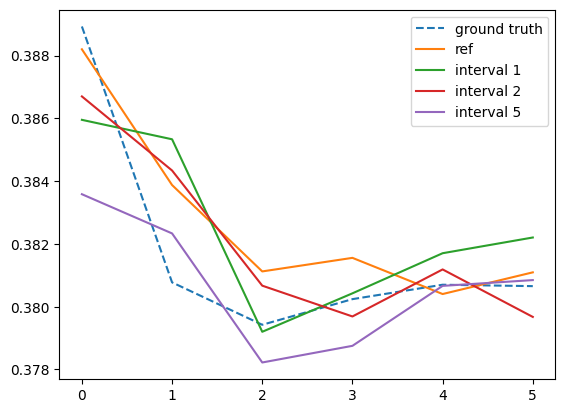

In [52]:
plt.plot(mean_gt, "--", label="ground truth")
plt.plot(ref_mean, label="ref")
plt.plot(inter_1_mean, label="interval 1")
plt.plot(inter_2_mean, label="interval 2")
plt.plot(inter_5_mean, label="interval 5")
plt.legend()